# Boilerplate

Package installation, loading, and dataloaders. There's also a simple model defined. You can change it your favourite architecture if you want.

In [1]:


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64
np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()

Sequential(
  (0): Normalize()
  (1): Net(
    (fc): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
  )
)

# Implement the Attacks

Functions are given a simple useful signature that you can start with. Feel free to extend the signature as you see fit.

You may find it useful to create a 'batched' version of PGD that you can use to create the adversarial attack.

In [3]:


def fgsm_untarget(model, x, y, eps):
    #TODO: implement this as an intermediate step of PGD
    # Notes: put the model in eval() mode for this function
    model.eval()

    x_prime = x.clone().detach()
    x_prime.requires_grad = True
    output = model(x_prime)
    loss = F.cross_entropy(output, y)
    loss.backward()

    gradient = x_prime.grad
    x_prime = x_prime + eps * gradient.sign()
    #x_prime = torch.clamp(x_prime, x-eps, x+eps)
    x_prime = torch.clamp(x_prime, 0, 1)

    return x_prime

def random_noise_attack(x, eps=0.2):
    noise = torch.randn_like(x) * eps
    x_prime = x + noise
    x_prime = torch.clamp(x_prime, 0, 1)
    return x_prime

def pgd_untargeted(model, x, y, k=10, eps=0.1, eps_step=0.01):
    #TODO: implement this 
    # Notes: put the model in eval() mode for this function
    # x: input image
    # y: ground truth label for x
    # k: steps of FGSM
    # eps: projection region for PGD (note the need for normalization before projection, as eps values are for inputs in [0,1])
    # eps_step: step for one iteration of FGSM
    model.eval()
    x_prime = x.clone().detach()
    x_prime += 2 * eps * (torch.rand_like(x_prime) - 0.5) # add a random noise to the initial x_prime
    x_prime = torch.clamp(x_prime, 0, 1)

    for i in range(k):
        x_prime = fgsm_untarget(model, x_prime, y, eps_step)
        # ensure x_primt in the l-infite ball zone
        x_prime = torch.clamp(x_prime, x + eps, x - eps)
        x_prime = torch.clamp(x_prime, 0, 1)

    return x_prime

# Implement Adversarial Training

In [4]:

def train_model(model, num_epochs, enable_defense=True, attack='pgd', eps=0.1, k=10):
    # Implementing the function to train the model on the MNIST dataset.
    # This function supports both standard and adversarial training.
    # Use the 'enable_defense' parameter to switch between training schemes.
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.95)
    
    for epoch in range(num_epochs):
        model.train()
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)
            if enable_defense:
                if attack == 'pgd':
                    data_adv = pgd_untargeted(model, data, target, k=k, eps=eps)
                    # Keep the original training data and add adversarial examples to it
                    data = torch.cat([data, data_adv], dim=0)
                    target = torch.cat([target, target], dim=0)
                else:
                    print('Attack not implemented, skipping')
            model.train()
            opt.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            opt.step()

In [10]:
import matplotlib.pyplot as plt

def visualize_cases(case_correct_both, case_correct_to_incorrect, case_incorrect_to_correct):
    import matplotlib.pyplot as plt

    cases = [
        ('Correct Before & After Attack', case_correct_both),
        ('Correct Before, Incorrect After Attack', case_correct_to_incorrect),
        ('Incorrect Before, Correct After Attack', case_incorrect_to_correct)
    ]

    for title, case in cases:
        if case is not None:
            fig, axes = plt.subplots(1, 2, figsize=(6, 3))
            axes[0].imshow(case['clean_image'].squeeze(), cmap='gray')
            axes[0].set_title(f"Clean Image\nTrue: {case['label']}, Pred: {case['pred_clean']}")
            axes[0].axis('off')
            axes[1].imshow(case['attack_image'].squeeze(), cmap='gray')
            axes[1].set_title(f"Adversarial Image\nTrue: {case['label']}, Pred: {case['pred_attack']}")
            axes[1].axis('off')
            plt.show()
        else:
            print(f"No example found for case: {title}")

def test_model_on_attacks(model, attack='pgd', eps=0.1):
    # TODO: implement this function to test the robust accuracy of the given model
    # use pgd_untargeted() within this function
    # model.eval()
    model.eval()
    
    correct = 0         # Correct predictions on clean data
    correct_under_attack = 0     # Correct predictions on adversarial data
    correct_both = 0
    tot = 0             # Total number of samples
    case_correct_both = None
    case_correct_to_incorrect = None
    case_incorrect_to_correct = None
    for x, y in test_loader:
        with torch.no_grad():
            output = model(x)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum()
        
        # Generate adversarial examples
        if attack == 'pgd':
            x_attack = pgd_untargeted(model, x, y, eps=eps)
        elif attack == 'fgsm':
            x_attack = fgsm_untarget(model, x, y, eps)
        elif attack == 'random':
            x_attack = random_noise_attack(x)
        else:
            print(f"Unsupported attack type: {attack}, skipping")
            continue
        
        # Evaluate model on adversarial examples
        with torch.no_grad():
            output_attack = model(x_attack)
            pred_attack = output_attack.argmax(dim=1, keepdim=True)
            correct_under_attack += pred_attack.eq(y.view_as(pred_attack)).sum().item()
        correct_both += sum(pred.eq(y.view_as(pred)) & pred_attack.eq(y.view_as(pred_attack)))
        tot += y.size(0)
    
        for i in range(len(y)):
            if case_correct_both is None and pred[i] == y[i] and pred_attack[i] == y[i]:
                case_correct_both = {
                    'clean_image': x[i].detach().cpu(),
                    'attack_image': x_attack[i].detach().cpu(),
                    'label': y[i].item(),
                    'pred_clean': pred[i].item(),
                    'pred_attack': pred_attack[i].item()
                }
            if case_correct_to_incorrect is None and pred[i] == y[i] and pred_attack[i] != y[i]:
                case_correct_to_incorrect = {
                    'clean_image': x[i].detach().cpu(),
                    'attack_image': x_attack[i].detach().cpu(),
                    'label': y[i].item(),
                    'pred_clean': pred[i].item(),
                    'pred_attack': pred_attack[i].item()
                }
            if case_incorrect_to_correct is None and pred[i] != y[i] and pred_attack[i] == y[i]:
                case_incorrect_to_correct = {
                    'clean_image': x[i].detach().cpu(),
                    'attack_image': x_attack[i].detach().cpu(),
                    'label': y[i].item(),
                    'pred_clean': pred[i].item(),
                    'pred_attack': pred_attack[i].item()
                }


    standard_accuracy = correct / tot
    roboust_accuracy = correct_both[0] / tot
    adversial_accuracy = correct_under_attack / tot
 
    
    print(f'Standard Accuracy: {standard_accuracy}')
    print(f'Robust Accuracy: {roboust_accuracy}')
    print(f"Adversial Accuracy:{adversial_accuracy}")
    visualize_cases(case_correct_both, case_correct_to_incorrect, case_incorrect_to_correct)

# Study Accuracy, Quality, etc.

Compare the various results and report your observations on the submission.

In [5]:
## train the original model
model = nn.Sequential(Normalize(), Net())
model = model.to(device)
model.train()

train_model(model, 20, False)
torch.save(model.state_dict(), 'weights.pt')

/var/folders/1n/w6t2b14d7sscxykjcvh220680000gn/T/ipykernel_67937/4055164685.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights.pt'

0.05
Standard Accuracy: 0.5360999703407288
Robust Accuracy: 0.5293999910354614
Adversial Accuracy:0.5301


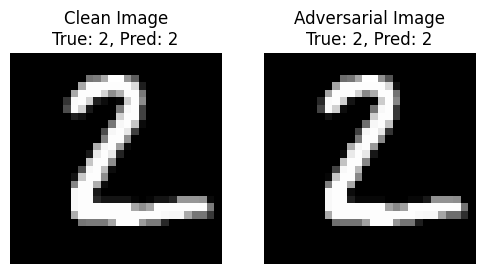

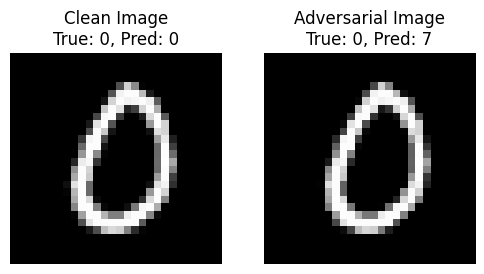

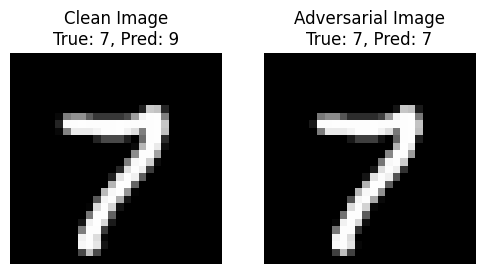

0.1
Standard Accuracy: 0.5360999703407288
Robust Accuracy: 0.5206999778747559
Adversial Accuracy:0.522


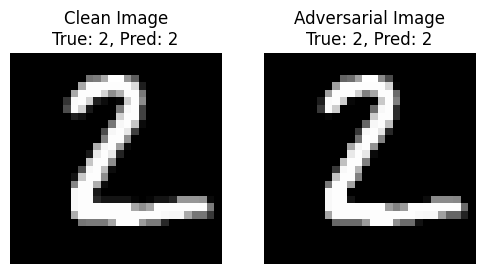

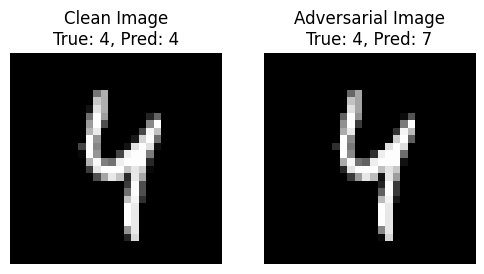

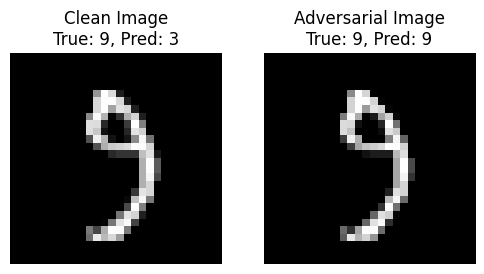

0.15
Standard Accuracy: 0.5360999703407288
Robust Accuracy: 0.5105999708175659
Adversial Accuracy:0.5123


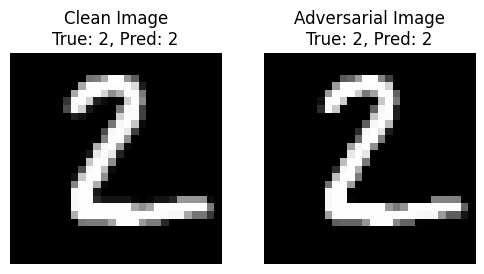

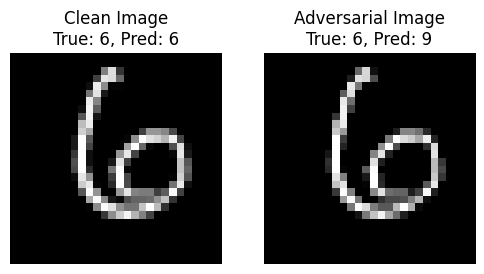

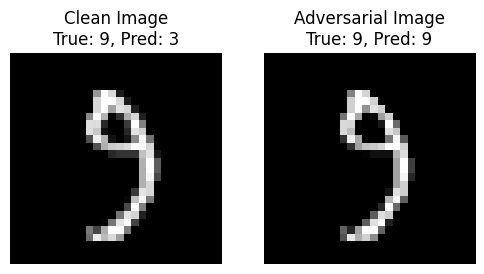

0.2
Standard Accuracy: 0.5360999703407288
Robust Accuracy: 0.498199999332428
Adversial Accuracy:0.5002


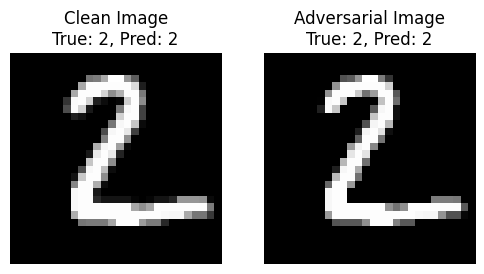

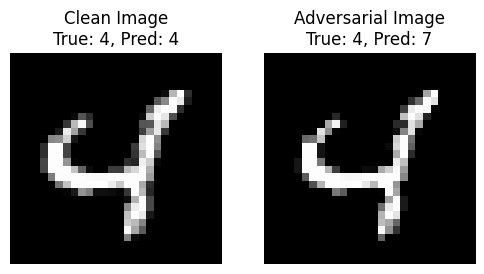

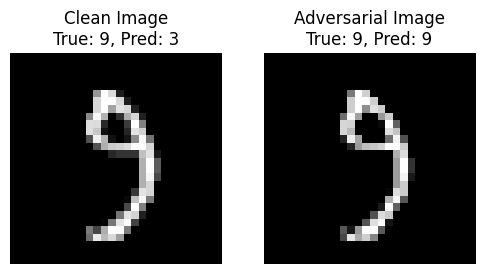

In [78]:
## PGD attack
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights.pt'))

for eps in [0.05, 0.1, 0.15, 0.2]:
    print(eps)
    test_model_on_attacks(model, attack='pgd', eps=eps)

In [6]:
## PGD based adversarial training
model = nn.Sequential(Normalize(), Net())
eps = 0.1
train_model(model, 20, True, 'pgd', eps, k=10)
torch.save(model.state_dict(), f'weights_AT_{eps}.pt')

In [11]:
## PGD attack
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights_AT_0.1.pt'))
print("Testing FGSM attack")
for eps in [0.05, 0.1, 0.15, 0.2]:
    print(eps)
    test_model_on_attacks(model, attack='fgsm', eps=eps)

/var/folders/1n/w6t2b14d7sscxykjcvh220680000gn/T/ipykernel_70519/2353668417.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights_AT_

Testing FGSM attack
0.05
Standard Accuracy: 0.7190999984741211
Robust Accuracy: 0.6366000175476074
Adversial Accuracy:0.6366
0.1
Standard Accuracy: 0.7190999984741211
Robust Accuracy: 0.6241999864578247
Adversial Accuracy:0.6245
0.15
Standard Accuracy: 0.7190999984741211
Robust Accuracy: 0.5889000296592712
Adversial Accuracy:0.5895
0.2
Standard Accuracy: 0.7190999984741211
Robust Accuracy: 0.5677000284194946
Adversial Accuracy:0.5685


In [12]:

model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights_AT_0.1.pt'))
print("Testing Random Noise attack")
for eps in [0.05, 0.1, 0.15, 0.2]:
    print(eps)
    test_model_on_attacks(model, attack='random', eps=eps)

/var/folders/1n/w6t2b14d7sscxykjcvh220680000gn/T/ipykernel_70519/3756250796.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights_AT_

Testing Random Noise attack
0.05
Standard Accuracy: 0.7190999984741211
Robust Accuracy: 0.6998000144958496
Adversial Accuracy:0.7555
0.1
Standard Accuracy: 0.7190999984741211
Robust Accuracy: 0.7008000016212463
Adversial Accuracy:0.7572
0.15
Standard Accuracy: 0.7190999984741211
Robust Accuracy: 0.6990000009536743
Adversial Accuracy:0.7539
0.2
Standard Accuracy: 0.7190999984741211
Robust Accuracy: 0.6973000168800354
Adversial Accuracy:0.7493


In [13]:
## PGD attack
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights_AT_0.1.pt'))
print("Testing PGD attack")
for eps in [0.05, 0.1, 0.15, 0.2]:
    print(eps)
    test_model_on_attacks(model, attack='pgd', eps=eps)

/var/folders/1n/w6t2b14d7sscxykjcvh220680000gn/T/ipykernel_70519/3217122685.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights_AT_

Testing PGD attack
0.05
Standard Accuracy: 0.7190999984741211
Robust Accuracy: 0.7150999903678894
Adversial Accuracy:0.717
0.1
Standard Accuracy: 0.7190999984741211
Robust Accuracy: 0.7087000012397766
Adversial Accuracy:0.7114
0.15
Standard Accuracy: 0.7190999984741211
Robust Accuracy: 0.7008000016212463
Adversial Accuracy:0.7044
0.2
Standard Accuracy: 0.7190999984741211
Robust Accuracy: 0.6924999952316284
Adversial Accuracy:0.697
